**Определение стоимости автомобилей**

**Описание**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную 
стоимость своего автомобиля. Есть исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости, конкретно модель, которая умеет её определять. Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель иследования**
- предсказать стоимость автомобиля.

**Ход исследования**

1. Загрузить данные, путь к файлу: `/datasets/autos.csv`.
2. Изучить данные. Заполнить пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
3. Подготовить выборки для обучения моделей.
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

**Что важно учесть при выполнении проекта**

Как известно данные не идельны. Во время загрузки, преоразования из одного формата в другой могут возникнуть технологические 
ошибки. Так же во время наполнения базы объявлений сотрудники могли допустить различные опечатки, либо перепутать переменные в столбцах, ведь человеческий фактор присутствует в любой сфере. Поэтому для качественного выполнения проекта необходимо основательно сделать предобработку данных и обратить внимание на следующие моменты:

1. описать найденные в данных проблемы,
2. применить различные методы: замену типов данных, обработку пропусков случайных, неслучайных и полностью случайных, обработку явных и не явных дубликатов,
3. использовать категоризацию данных,
4. применить четкую  структуру проекта и придерживаться хорошего стиля при написании кода,
5. обозначить выводы по этапам,
6. кратко комментировать шаги,
7. использовать срезы данных,
8. построить графики для решения задич,
9. использовать различные методы построения графиков,
10. использовать сводные таблицы для вывода данных,
11. объяснить, как коррелируют между собой различные величины или показатели. 


# Исследовательский анализ данных

Исследовательский анализ данных (Exploratory Data Analysis, EDA) — является важным этапом, который позволяет лучше понять данные и выявить основные характеристики и закономерности. Все выявленные проблемы на данном этапе будут исправлены в шаге предобработки данных.

In [1]:
# !pip install catboost -q
# !pip install phik -q 
# !pip install imblearn -q 
# pip3 install -U scikit-learn -q
# !pip3 install seaborn -q

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random
import time
import seaborn as sns
from scipy import stats as st
from catboost import (
    Pool, 
    CatBoostRegressor,
    cv
)
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder,
    FunctionTransformer
)
from sklearn.metrics import ( 
    mean_squared_error
)
import warnings
from imblearn.combine import SMOTETomek
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# вывод всех столбцов и строк, независимо от их количества.
pd.set_option('display.max_columns', None)

# отключаем предупреждение
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

## Загрузка данных

In [2]:
try:
    data = pd.read_csv('.../autos.csv')
    
except:
    data = pd.read_csv('.../autos.csv')

In [4]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# сохраним количество сырых данных
data_stock = data.shape[0]

## Соответствие техническому описанию

Для этой задачи заказчик предоставил данные с признаками:

- _DateCrawled_ — дата скачивания анкеты из базы
- _VehicleType_ — тип автомобильного кузова
- _RegistrationYear_ — год регистрации автомобиля
- _Gearbox_ — тип коробки передач
- _Power_ — мощность (л. с.)
- _Model_ — модель автомобиля
- _Kilometer_ — пробег (км)
- _RegistrationMonth_ — месяц регистрации автомобиля
- _FuelType_ — тип топлива
- _Brand_ — марка автомобиля
- _Repaired_ — была машина в ремонте или нет
- _DateCreated_ — дата создания анкеты
- _NumberOfPictures_ — количество фотографий автомобиля
- _PostalCode_ — почтовый индекс владельца анкеты (пользователя)
- _LastSeen_ — дата последней активности пользователя

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Таблицы соответствуют техническому описанию, присутствуют пропуски в столбцах:

- VehicleType
- Gearbox
- Model
- FuelType
- Repaired

Измениним формат данных в следующих столбцах для быстродействия:
- Price - int32
- RegistrationYear - int16
- Power - int16
- Kilometer - int32
- RegistrationMonth - int32
- NumberOfPictures - int8

Исключим следующие не информативные столбцы из исследования:
- DateCrawled
- DateCreated
- NumberOfPictures
- PostalCode
- LastSeen


In [7]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

## Дубликаты

In [8]:
data.duplicated().sum()

45040

In [9]:
data.duplicated(keep=False).sum()

76590

In [10]:
def count_duplicates(df):
    # Создаем список для хранения результатов
    duplicates_summary = []

    # Проходим по каждому столбцу DataFrame
    for column in df.columns:
        # Проверяем дубликаты в текущем столбце
        duplicate_count = df[column].duplicated(keep=False).sum()
        
        # Добавляем результат в список
        duplicates_summary.append({'Column': column, 'Duplicate Count': duplicate_count})

    # Преобразуем список в DataFrame
    duplicates_summary = pd.DataFrame(duplicates_summary)

    # Сортируем по количеству дубликатов
    duplicates_summary = (
        duplicates_summary
        .sort_values(by='Duplicate Count', ascending=False)
        .set_index('Column')
        .T
    )

    # Выводим итоговую таблицу
    display(duplicates_summary)

In [11]:
count_duplicates(data)

Column,VehicleType,Gearbox,Model,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Power,Price
Duplicate Count,354369,354369,354369,354369,354369,354369,354369,354329,354116,352979


In [12]:
data.FuelType.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

В столбце **FuelType** присутствуют не явные дубликаты. Слова petrol и gasoline по сути являются синонимами, которые обозначают слово бензин, но в разных странах. 

## Статистический анализ

In [13]:
(
    data
    .select_dtypes(include='number')
    .describe()
    .style.format('{:,.2f}')
)

,Price,RegistrationYear,Power,Kilometer
count,"354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17"
std,"4,514.16",90.23,189.85,"37,905.34"
min,0.00,"1,000.00",0.00,"5,000.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00"


Присутствуют нулевые значения в столбце Price. Необходимо фильтровать данные, так как эти значения для предсказания 
цены не имеет практической пользы.

In [14]:
np.sort(data.RegistrationYear.unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

В столбце **RegistrationYear** присутствуют аномальные зачения, фильтруем по году от 1950 до 2019. Автомобили старше 1950 года являются раритетными и требуют специальной оценки. В нашем случае задача состоит в определении стоимости наиболее массовых автомобилей.

In [15]:
np.sort(data.Power.unique())

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

В столбце **Power** присутствуют аномальые зачения.

## Визуализация

### Количественные признаки

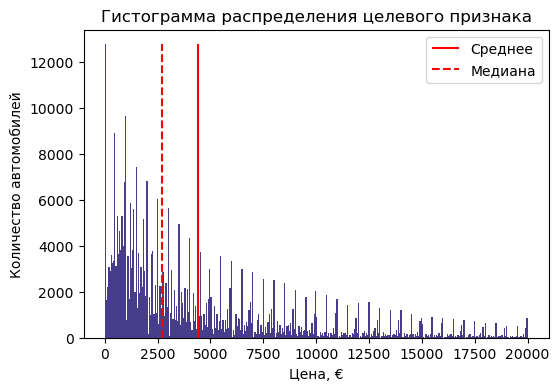

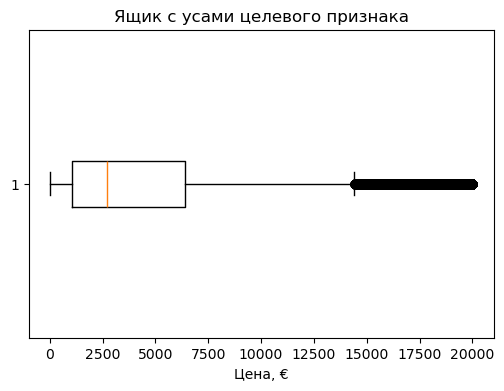

In [24]:
# распределение целевого признака Price
plt.rcParams["figure.figsize"] = (6, 4)
bins = plt.hist(
    data['Price'], 
    bins=356, 
    color='darkslateblue'
)
plt.vlines(
    x=data['Price'].mean(),
    colors='red', 
    ymin=bins[0].min(), 
    ymax=bins[0].max(), 
    label='Среднее'
)
plt.vlines(
    x=data['Price'].median(), 
    colors='red', 
    ymin=bins[0].min(), 
    ymax=bins[0].max(), 
    linestyles='--', 
    label='Медиана'
)
plt.title('Гистограмма распределения целевого признака')
plt.xlabel('Цена, €')
plt.ylabel('Количество автомобилей')
plt.legend()
plt.show()

# ящик с усами целевого признака
plt.title('Ящик с усами целевого признака')
plt.boxplot(x=data['Price'], vert=False)
plt.xlabel('Цена, €')
plt.show()

Целевой признак имеет экспоненциальное распределение. В количественных столбцах есть выбросы, фильтруем их на этапе предобработки.

### Категориальные признаки

In [20]:
def hist_countolot(data, x, xlabel, **kwargs):
    """
    data - датафрейм
    x - ость, по которой распределяются значения количественного признака
    xlabel, ylabel - название осей
    **kwargs:
     - loc=('loc', 'best') - если он был задан, использовать значение по умолчанию 'best' либо
       upper right и т.д.
    """
    
    # создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # уникальные категории
    categories = data.VehicleType.unique()

    # случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}

    # гистограмма
    plt.figure(figsize=(10, 4))
    ax = sns.countplot(
        data=data,
        x=x, 
        palette=colors_hist,
        hue='VehicleType', 
        stat='percent'
    )
    ax.set_title('График распределения категориального признака', fontsize=9)

    # Настраиваем ось Y для отображения целых чисел
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.title('График распределения категориального признака', fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    
    # Исправленный вызов legend
    plt.legend(title='Тип автомобильного кузова', loc=kwargs.get('loc', 'best'), **kwargs)

    plt.show()


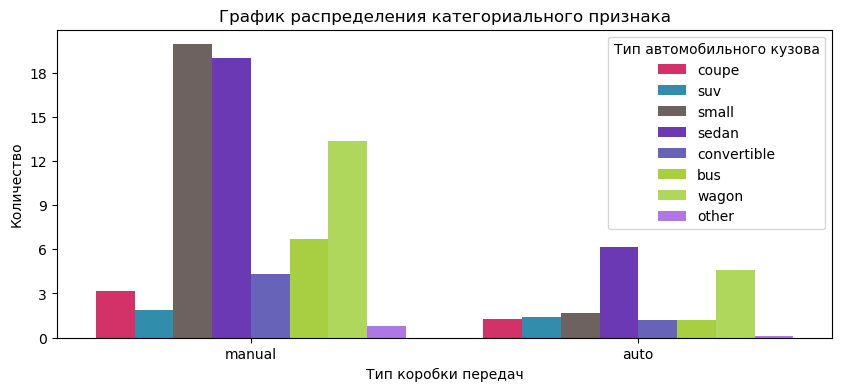

In [21]:
# Gearbox
hist_countolot(
    data, 
    'Gearbox', 
    'Тип коробки передач'
) 

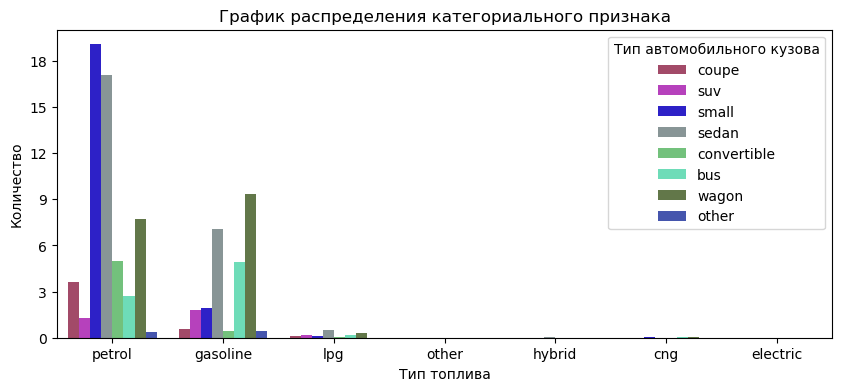

In [23]:
# FuelType
hist_countolot(
    data, 
    'FuelType', 
    'Тип топлива'
) 

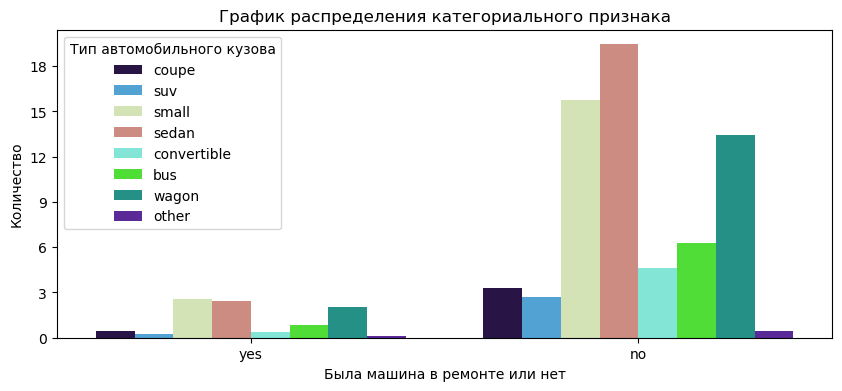

In [22]:
# Repaired
hist_countolot(
    data, 
    'Repaired', 
    'Была машина в ремонте или нет'
) 

### Корреляционный анализ

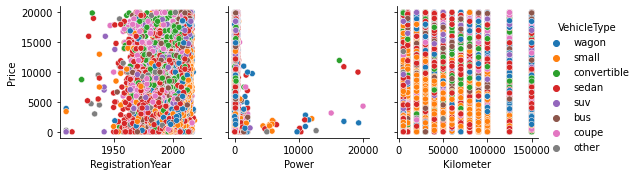

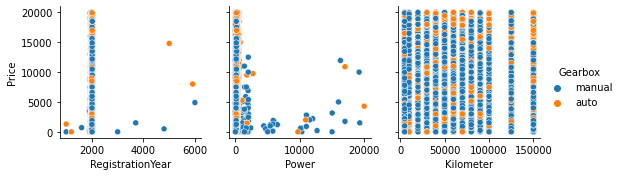

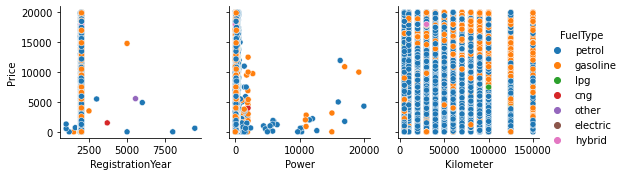

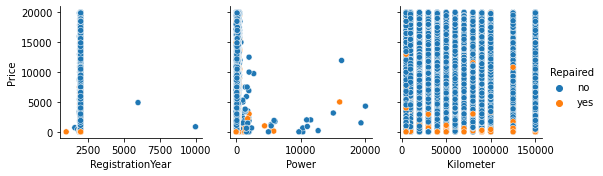

In [21]:
cat = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
#data.select_dtypes(exclude='number').drop(['Model', 'Brand'], axis=1).columns
for category in cat:
    g = sns.PairGrid(
        data.sample(frac=0.3, random_state=42), 
        hue=category, 
        x_vars=(
            data
            .select_dtypes(include='number')
            .drop(['Price'], axis=1)
            .columns
        ),
        y_vars='Price'
    )
    g.map(sns.scatterplot)
    g.add_legend()
    plt.show()

На диаграммах нет четкой тенденции распрелеления данных - корреляция между целевым и количественными признаками отсутствует.

In [22]:
# считаем корреляцию
phik_overview = phik_matrix(
    data,
    interval_cols=(
        data
        .select_dtypes(include='number')
        .columns
    ) 
)

# размер матрицы
phik_overview.shape

(10, 10)

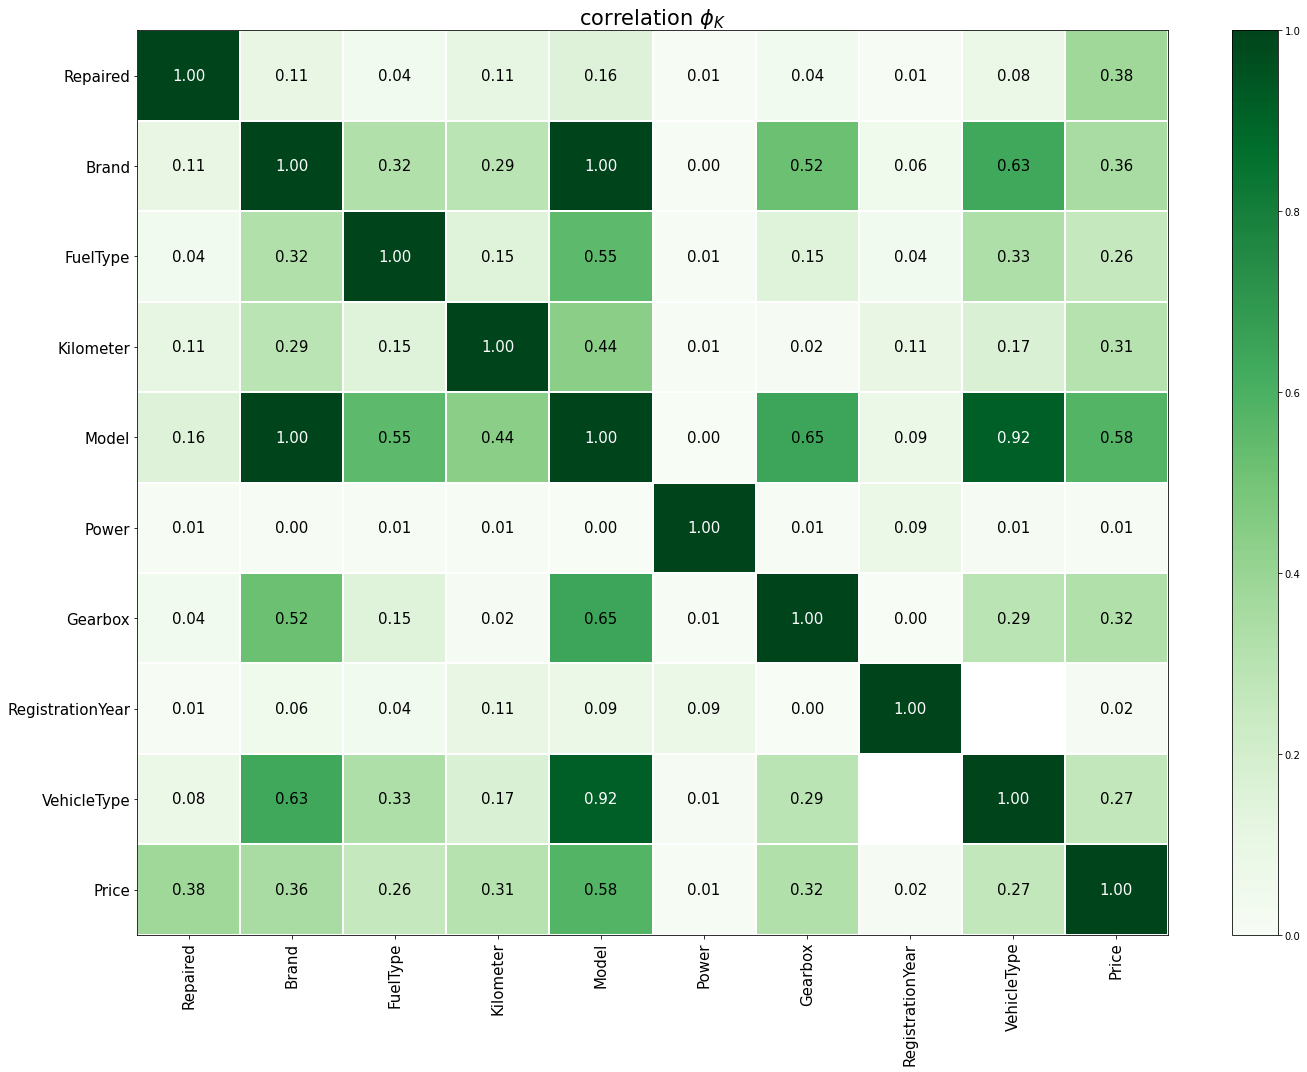

In [23]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Присутствует мультикорреляция между Brand - Model и VehicleType - Model. При обучении модели необходимо использовать методы регуляризации, такие как Lasso (L1-регуляризация) или Ridge (L2-регуляризация), так как они могут уменьшить влияние коррелирующих признаков на модель.

# Предобработка данных

Подготовка данных для анализа называется предобработкой. Нужно оценить масштаб найденных проблем и устранить их. Предобработка следует принципу GIGO (от англ. garbage in — garbage out, буквально «мусор на входе — мусор на выходе»). Это значит, что при ошибках во входных данных даже правильный алгоритм работы приведёт к неверным результатам. Так же нужно помнить об законе экономии, который называется Бри́тва О́ккама. В нем говорится следующее: Не следует множить сущее без необходимости. Суть принципа: совершенство должно быть простым. Если какого-то результата можно достичь с привлечением сущностей A, B и C либо другим путём с привлечением A, B, С и D — надо выбирать первый путь. В плане программирования это значит, что не следут создавать промежуточные переменные, которые не пригодяться в дальнейшем.

Кастомный трансформер предобработки

In [24]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, thresholds={'Price': 1.5, 'RegistrationYear': 1.5, 'Power': 1.5}):
        self.thresholds = thresholds

    def fit(self, X, y=None):
        # Сохраним медианы для замены выбросов
        self.median_power = X['Power'].median()  # Медиана для 'Power'
        self.median_registration_year = X['RegistrationYear'].median()  # Медиана для 'RegistrationYear'
        self.median_kilometer = X['Kilometer'].median()  # Для 'Kilometer'
        self.median_price = X['Price'].median()  # Медиана для 'Price'
        return self

    def transform(self, X):
        X_len_stock = X.shape[0]

        # Категориальные признаки
        # Исправить не явные дубликаты в столбце
        X['FuelType'] = X['FuelType'].replace('petrol', 'gasoline')
        
        # Заполнить пропуски в столбцах
        vehicle_type = X.groupby('Model')['VehicleType'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
        gearbox = X.groupby('Model')['Gearbox'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
        fuel_type = X.groupby('Model')['FuelType'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

        X['VehicleType'] = X['VehicleType'].fillna(X['Model'].map(vehicle_type))
        X['Gearbox'] = X['Gearbox'].fillna(X['Model'].map(gearbox))
        X['FuelType'] = X['FuelType'].fillna(X['Model'].map(fuel_type))

        # Заменить оставшиеся пропуски на значение unknown
        X[['VehicleType', 'Gearbox', 'FuelType', 'Repaired']] = X[['VehicleType', 'Gearbox', 'FuelType', 'Repaired']].fillna('unknown')

        # Заполнить пропуски в столбце Model
        mask = X['Model'].isna()
        missing_models = X[mask]
        merged = missing_models.merge(
            X[['VehicleType', 'Gearbox', 'FuelType', 'RegistrationYear', 'Model']],
            on=['VehicleType', 'Gearbox', 'FuelType', 'RegistrationYear'],
            how='left',
            suffixes=('', '_matched')
        )
        X.loc[mask, 'Model'] = merged['Model_matched']

        # Заполнить оставшиеся пропуски на значение unknown
        X['Model'] = X['Model'].fillna('unknown')

        # Числовые признаки
        # Преобразование строковых значений в NaN в числовых столбцах
        for col in X.select_dtypes(include=['float64', 'int64']).columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # Заполнить пропуски в 'RegistrationYear', 'Power' и 'Kilometer' медианами
        X['Power'].fillna(self.median_power, inplace=True)
        X['RegistrationYear'].fillna(self.median_registration_year, inplace=True)
        X['Kilometer'].fillna(self.median_kilometer, inplace=True)
        
        # Исключить строки с нулем из столбца Price
        X = X[X['Price'] != 0]

        # Создадим DataFrame для хранения границ выбросов
        outlier_info = pd.DataFrame(columns=['Feature', 'Threshold', 'Lower Bound', 'Upper Bound'])
        
        # Убрать выбросы (аномалии) из количественных признаков RegistrationYear и Power
        for column in ['Price', 'RegistrationYear', 'Power']:
            thresholds = self.thresholds[column]
            lower_bound = (
                X[column].quantile(0.25) * thresholds# - thresholds * (X[column].quantile(0.75) - X[column].quantile(0.25))
            )
            upper_bound = (
                X[column].quantile(0.75) + thresholds * (X[column].quantile(0.75) - X[column].quantile(0.25))
            )

            # Добавляем информацию о выбросах в DataFrame
            outlier_info = pd.concat([
                outlier_info,
                pd.DataFrame([{
                    'Feature': column,
                    'Threshold': thresholds,
                    'Lower Bound': lower_bound,
                    'Upper Bound': upper_bound
                }])
            ], ignore_index=True)

            
            median_value = self.median_price if column == 'Price' else self.median_power
            X[column] = np.where((X[column] < lower_bound) | (X[column] > upper_bound), median_value, X[column])
                
        # Выводим таблицу с информацией о выбросах
        display(outlier_info.set_index('Feature').T)

        # Изменить формат данных в столбцах
        X[['Price', 'Kilometer']] = X[['Price', 'Kilometer']].astype('int32')
        X[['RegistrationYear', 'Power']] = X[['RegistrationYear', 'Power']].astype('int16')

        # Cравнить количество оставшихся строк с оригиналом
        print(f"Исходное количество строк: {X_len_stock}")
        print(f"Количество строк после предобработки: {X.shape[0]}")
        print(f"Потеря данных: {round((100 - (X.shape[0] / X_len_stock) * 100), 2)}%")

        return X

In [25]:
pipe_pre = Pipeline(
    [
        ('custom_transformer', CustomTransformer(thresholds={'Price': 0.15, 'RegistrationYear': 0.98, 'Power': 1}))
    ]
)
data_pre = pipe_pre.fit_transform(data)

Feature,Price,RegistrationYear,Power
Threshold,0.15,0.98,1.0
Lower Bound,180.00,1959.02,69.0
Upper Bound,7295.00,2016.82,217.0


Исходное количество строк: 354369
Количество строк после предобработки: 343597
Потеря данных: 3.04%


# Обучение модей

Для решения задачи линейной регрессии обучим три модели: CatBoostRegressor, LGBMRegressor и RandomForestRegressor.

In [36]:
# label_encoders = {}
# for column in cat_columns:
    # le = LabelEncoder()
    # data_random[column] = le.fit_transform(data_random[column])

In [37]:
# X_train_rf, X_valid_rf, y_train_rf, y_valid_rf = (
    # train_test_split(
        # data_random.drop(['Price'],axis=1),
        # data_random.Price,
        # test_size = VALID_SIZE,
        # random_state = RANDOM_STATE
    # )
# )

In [38]:
# Настройка RandomForestRegressor
# rf_model = RandomForestRegressor(
    # n_estimators=100,
    # max_depth=None,
    # min_samples_split=2,
    # min_samples_leaf=1,
    # random_state=42
# )

In [39]:
# rf_learn_time = time.time()
# rf_model.fit(X_train_rf, y_train_rf)
# rf_learn_end = round((time.time() - rf_learn_time), 1)
# print(f'Wall time: {rf_learn_end} seconds')

In [40]:
# rf_pred_time = time.time()
# rf_preds = rf_model.predict(X_valid_rf)
# rf_rmse = int(np.sqrt(mean_squared_error(y_valid_rf, rf_preds)))
# rf_pred_end = round((time.time() - rf_pred_time), 1)
# print(f'Random Forest RMSE: {rf_rmse}')

In [41]:
RANDOM_STATE = 42 
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = (
    train_test_split(
        data_pre.drop(['Price'],axis=1),
        data_pre.Price,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE
    )
)

cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Преобразуем категориальные признаки в тип category
for col in cat_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [42]:
# CatBoostRegressor
pool = Pool(data=X_train, label=y_train, cat_features=cat_columns)
params = {
    'loss_function': 'RMSE',
    'iterations': 500,
    'learning_rate': 0.5,
    'depth': 6,
    'l2_leaf_reg': 3,
    'eval_metric': 'RMSE',
    'verbose': 100,
    'random_seed': RANDOM_STATE
}

cat_learn_time = time.time()
cat_cv = cv(
    params=params,
    pool=pool,
    fold_count=5,
    partition_random_seed=RANDOM_STATE,
    #verbose=False,
    logging_level='Silent'
)
cat_learn_end = round((time.time() - cat_learn_time), 1)
cat_rmse = int(cat_cv['test-RMSE-mean'].mean())

In [43]:
# LGBMRegressor
lgbm_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=RANDOM_STATE
)

lgbm_learn_time = time.time()
lgbm_cv = cross_val_score(
    lgbm_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
lgbm_learn_end = round((time.time() - lgbm_learn_time), 1)
lgbm_rmse = int(np.mean(-lgbm_cv))

In [44]:
# RandomForestRegressor
data_random = data_pre.copy()
label_encoders = {}

for column in cat_columns:
    le = LabelEncoder()
    data_random[column] = le.fit_transform(data_random[column])
    
X_train_rf, X_test_rf, y_train_rf, y_test_rf = (
    train_test_split(
        data_random.drop(['Price'],axis=1),
        data_random.Price,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE
    )
)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

rf_learn_time = time.time()
rf_cv = cross_val_score(
    rf_model,
    X_train_rf,
    y_train_rf,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
rf_learn_end = round((time.time() - rf_learn_time), 1)
rf_rmse = int(np.mean(-rf_cv))

# Анализ результатов обучения

In [45]:
(
    pd.DataFrame({
        'Тип модели': ['CatBoostRegressor', 'LGBMRegressor', 'RandomForestRegressor'],
        'Время обучения': [cat_learn_end, lgbm_learn_end, rf_learn_end],
        'Значение метрики RMSE': [cat_rmse, lgbm_rmse, rf_rmse],
        })
    .set_index('Тип модели')
    .T
    )


Тип модели,CatBoostRegressor,LGBMRegressor,RandomForestRegressor
Время обучения,589.9,187.2,261.9
Значение метрики RMSE,1077.0,1032.0,1064.0


Опираясь на критерии, которые важны заказчику, определяем лучшую модель - LGBMRegressor. Выполним передсказание на лучшей модели

In [46]:
lgbm_model.fit(X_train, y_train, categorical_feature=cat_columns)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMRegressor(n_estimators=1000, random_state=42, reg_alpha=0.1, reg_lambda=0.1)

In [47]:
lgbm_pred_time = time.time()
lgbm_preds = lgbm_model.predict(X_test)
lgbm_pred_end = round((time.time() - lgbm_pred_time), 1) 
print(f"Wall time: {lgbm_pred_end} seconds")

Wall time: 8.8 seconds
